# SHAP XAI Method Explanation

Here are the resources we used to implement the SHAP method:
- https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/image.html  

The SHAP documentation provided all the code we needed, making the implementation straightforward.

Start by importing the needed libraries:

In [ ]:
import shap
from PIL import Image
import numpy as np
from pathlib import Path
import os
import tensorflow as tf

c:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Load a test image from the image dataset:

We select an image from the public samples and resize it to 224x224 pixels (the expected input size for MobileNetV2), converting it to RGB format.

In [ ]:
true_label = "absent"
img_test_path = next((Path(os.getcwd()).parent.parent / "frontend" / "public" / "image" / "present").iterdir())
img_array = np.array(Image.open(img_test_path).convert('RGB').resize((224, 224)))
img_array.shape

(224, 224, 3)

Reshape the image to add a batch dimension:

Neural networks expect batched inputs with shape (batch_size, height, width, channels). We expand dimensions from (224, 224, 3) to (1, 224, 224, 3).

In [4]:
img_batch = np.expand_dims(img_array, axis=0)
img_array.shape, img_batch.shape

((224, 224, 3), (1, 224, 224, 3))

Load the fine-tuned classification model and define class names:

We load the MobileNetV2 model fine-tuned for multi-label chest X-ray classification. The class names array maps the model's output indices to human-readable condition labels.

In [ ]:
model_path = Path(os.getcwd()).parent.parent / "backend" / "models" / "image" / "mobilenet-v2" / "model.keras"
model = tf.keras.models.load_model(model_path)
class_names = [
    "No Finding",
    "Enlarged Cardiomediastinum",
    "Cardiomegaly",
    "Lung Opacity",
    "Lung Lesion",
    "Edema",
    "Consolidation",
    "Pneumonia",
    "Atelectasis",
    "Pneumothorax",
    "Pleural Effusion",
    "Pleural Other",
    "Fracture",
    "Support Devices"
]

Initialize the SHAP masker and explainer for image explanation:

The masker uses "inpaint_telea" algorithm to intelligently fill masked regions during perturbation. The explainer will systematically mask different image regions to measure their impact on the model's predictions.

In [7]:
masker = shap.maskers.Image("inpaint_telea", img_batch[0].shape)
explainer = shap.Explainer(model, masker, output_names=class_names)

Compute SHAP values to explain the model's prediction:

This step may take several minutes. SHAP evaluates up to 2000 masked variations of the image to determine each pixel region's contribution to the prediction. We focus on the top predicted class.

In [8]:
shap_values = explainer(img_batch, max_evals=2000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

PartitionExplainer explainer: 2it [02:46, 166.88s/it]              


Display the SHAP visualization:

The visualization shows the original image with color-coded overlays: red regions increase the prediction probability (positive contribution), while blue regions decrease it (negative contribution).

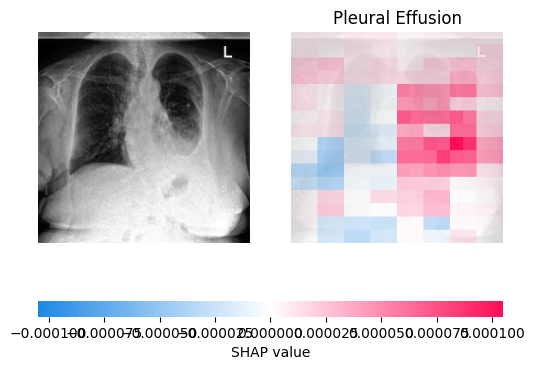

In [9]:
shap.image_plot(shap_values)    